In [405]:
%matplotlib notebook
import datetime
import obspy
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

N=7
minM = 4.9
lon=[-110,-70]
lat=[-10,30]
net='NU'
end = (datetime.datetime.now()).isoformat()
start = (datetime.datetime.now()-datetime.timedelta(days=N)).isoformat()

# Review of the earthquake early warning system for the N days. 

In [406]:
print('N: %s' % str(N))
print('into area %s°N %s°E' % (str(lat), str(lon)))
print("from %s" % start )
print("  to %s" % end )
print('for network %s.' % net)

N: 7
into area [-10, 30]°N [-110, -70]°E
from 2017-02-16T19:19:16.544217
  to 2017-02-23T19:19:16.544131
for network NU.


## Global observations

<IPython.core.display.Javascript object>


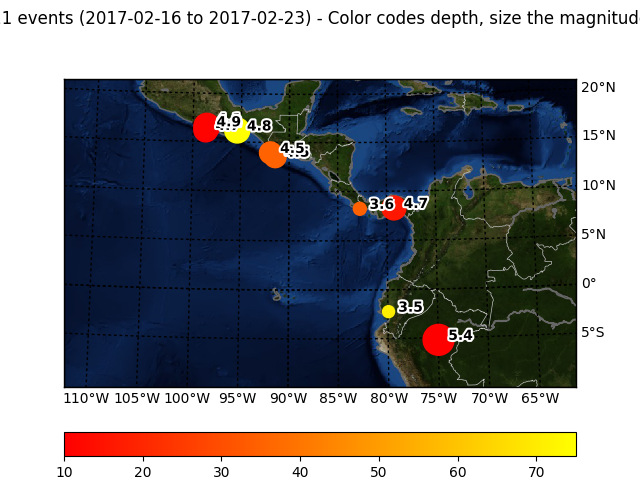

In [407]:
url="http://earthquake.usgs.gov/fdsnws/event/1/query.quakeml?starttime="+start+"&endtime="+end+"&minlat="+str(lat[0])+"&maxlat="+str(lat[1])+"&minlon="+str(lon[0])+"&maxlon="+str(lon[1])+"&orderby=magnitude-asc"
cat = obspy.read_events(str(url))
#url="https://service.iris.edu/fdsnws/station/1/query?starttime="+start+"&endtime="+end+"&minlat=-10&maxlat=30&minlon=-110&maxlon=-70&level=station&format=xml&nodata=404"
#inv = obspy.read_inventory(str(url))
fig = cat.plot(projection='local',resolution='i',continent_fill_color='None',water_fill_color='None',colormap='autumn')
fig.bmap.bluemarble()

## INETER observations
### Available network

<IPython.core.display.Javascript object>


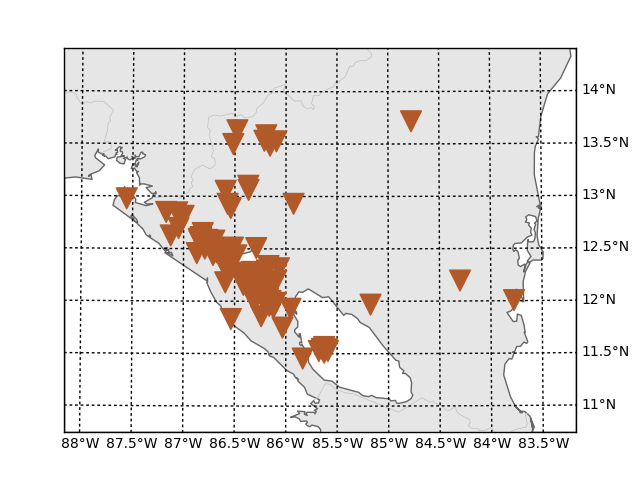

In [408]:
url="http://165.98.224.52:8081/fdsnws/station/1/query?starttime="+start+"&endtime="+end+"&net="+net+"&level=station&format=xml&nodata=404"
inv = obspy.read_inventory(str(url))
fig = inv.plot(projection='local',resolution='i', label=True)

### Observed earthquakes

<IPython.core.display.Javascript object>


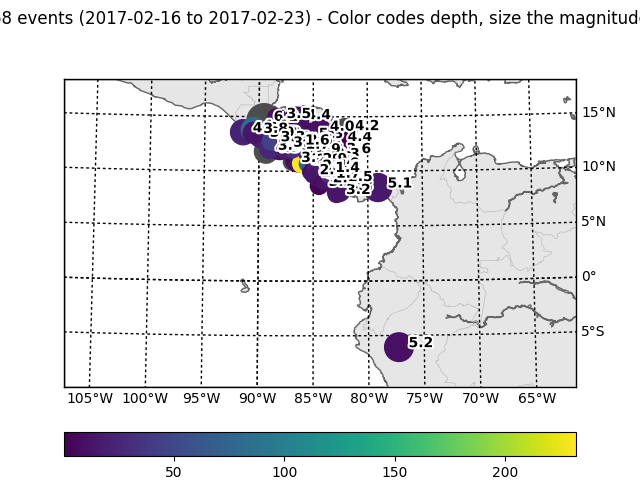

68 Event(s) in Catalog:
2017-02-21T07:15:14.338108Z | +14.613,  -89.548 | 6.184471105 M  | manual
2017-02-18T18:13:31.480591Z | +13.057,  -85.389 | 5.30898918 M  | automatic
...
2017-02-23T11:27:27.298881Z | +12.447,  -86.651 | 1.638089285 M  | manual
2017-02-22T06:09:09.785585Z |  +9.942,  -83.861 | 1.392265954 M  | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [409]:
url="http://165.98.224.52:8081/fdsnws/event/1/query?starttime="+start+"&endtime="+end+"&orderby=magnitude"
cat = obspy.read_events(str(url))
fig = cat.plot(projection='local',resolution='i')#,continent_fill_color='None',water_fill_color='None')#,colormap='autumn')
print(cat)

### The most important earthquakes

<IPython.core.display.Javascript object>


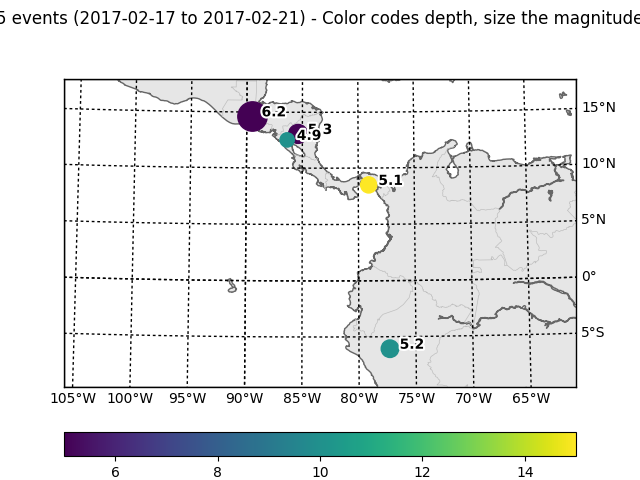

5 Event(s) in Catalog:
2017-02-21T07:15:14.338108Z | +14.613,  -89.548 | 6.184471105 M  | manual
2017-02-18T18:13:31.480591Z | +13.057,  -85.389 | 5.30898918 M  | automatic
2017-02-20T07:45:13.676429Z |  -6.078,  -77.285 | 5.188626513 M  | manual
2017-02-20T19:35:48.206558Z |  +8.502,  -79.069 | 5.073081339 M  | manual
2017-02-17T02:53:28.699011Z | +12.517,  -86.366 | 4.918598008 M  | automatic


In [410]:
url="http://165.98.224.52:8081/fdsnws/event/1/query?starttime="+start+"&endtime="+end+"&minmag="+str(minM)+"&orderby=magnitude"
subcat = obspy.read_events(str(url))
fig = subcat.plot(projection='local',resolution='i')#,continent_fill_color='None',water_fill_color='None',colormap='autumn')
fig.bmap.bluemarble()
print(subcat)

## Observations by INETER EEW

<IPython.core.display.Javascript object>


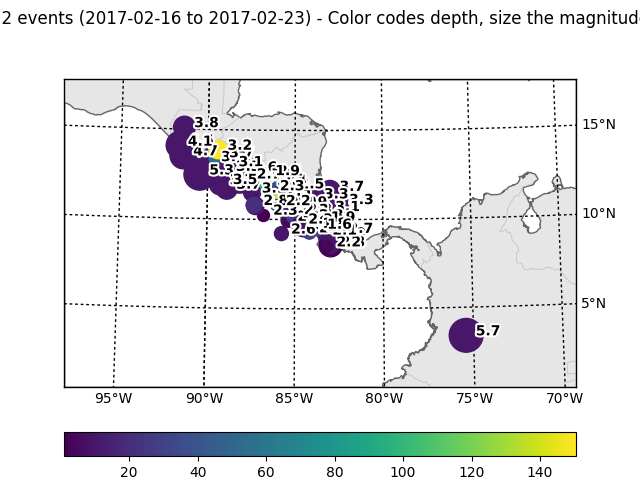

72 Event(s) in Catalog:
2017-02-21T14:12:30.428596Z |  +3.420,  -75.416 | 5.686401657 M  | automatic
2017-02-17T23:35:16.282402Z | +12.468,  -90.459 | 5.316994555 M  | automatic
...
2017-02-20T07:14:24.913445Z |  +9.543,  -83.977 | 1.827975687 M  | automatic
2017-02-22T10:02:02.543972Z |  +9.491,  -83.706 | 1.608906249 M  | automatic
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [411]:
url="http://localhost:18080/fdsnws/event/1/query?starttime="+start+"&endtime="+end+"&orderby=magnitude&includeallorigins=true&includeallmagnitudes=true"
eewcat = obspy.read_events(str(url))
fig = eewcat.plot(projection='local',resolution='i')#,continent_fill_color='None',water_fill_color='None')#,colormap='autumn')
print(eewcat)

### How consistent are EEW and main systems ?

In [412]:
missed_main = obspy.core.event.Catalog()
missed_eew = obspy.core.event.Catalog()
falses_eew = obspy.core.event.Catalog()
#falses_main = obspy.core.event.Catalog()
eewcat_checked = obspy.core.event.Catalog()

for e in eewcat.events:
    o = e.preferred_origin() or e.origins[-1]
    found=False 
    real=False
    
    for ref in cat.events: 
        refo = ref.preferred_origin() or ref.origins[-1]
        refm = ref.preferred_magnitude() or ref.magnitudes[-1] 
        if abs(o.time-refo.time) < 60: # These 2 match
            found=True  
            foundo = refo.copy()
            foundm = refm.copy()
            if refo.evaluation_mode != 'automatic' and refm.evaluation_mode != 'automatic' : # the ref eq is real
                real = True 
            if ref.event_type == 'earthquake':     # the ref eq is real
                real = True
            if e.event_type == 'earthquake':       # the eew eq is real
                real = True
    if not found:
        if not real: # misfit & fake
            falses_eew.append(e)
        else:        # misfit but real eq
            missed_main.append(e)
    else:
        if not real: # match & fake
            falses_eew.append(e)
        else:        # match & real eq (eew origins + ref origin)
            eewcat_checked.events.append(e)
            eewcat_checked.events[-1].origins.append(foundo)
            eewcat_checked.events[-1].magnitudes.append(foundm)            

## Misfits 
### False alarms
Not identified as earthquakes.

<IPython.core.display.Javascript object>


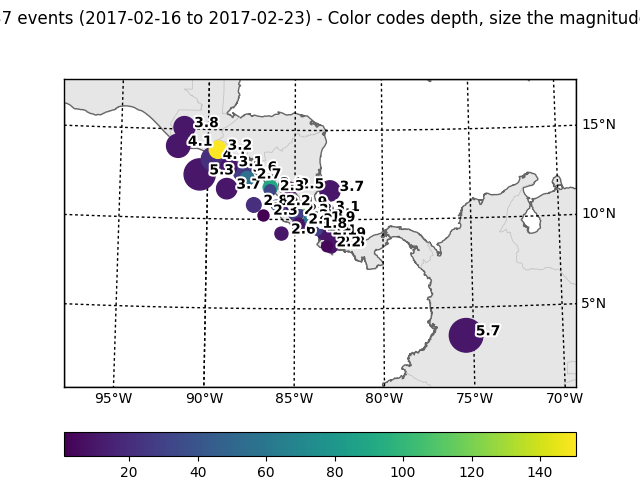

37 Event(s) in Catalog:
2017-02-21T14:12:30.428596Z |  +3.420,  -75.416 | 5.686401657 M  | automatic
2017-02-17T23:35:16.282402Z | +12.468,  -90.459 | 5.316994555 M  | automatic
...
2017-02-20T10:24:30.023194Z |  +9.896,  -83.505 | 1.895371128 M  | automatic
2017-02-20T07:14:24.913445Z |  +9.543,  -83.977 | 1.827975687 M  | automatic
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [413]:
if len(falses_eew)>0:
    falses_eew.plot(projection='local',resolution='i')
print(falses_eew)

### Missing in INETER main system

In [414]:
if len(missed_main)>0:
    missed_main.plot(projection='local',resolution='i')
print(missed_main)

0 Event(s) in Catalog:



## Consistent INETER EEW catalog
### Consistent 1rst Mvs ?

<IPython.core.display.Javascript object>


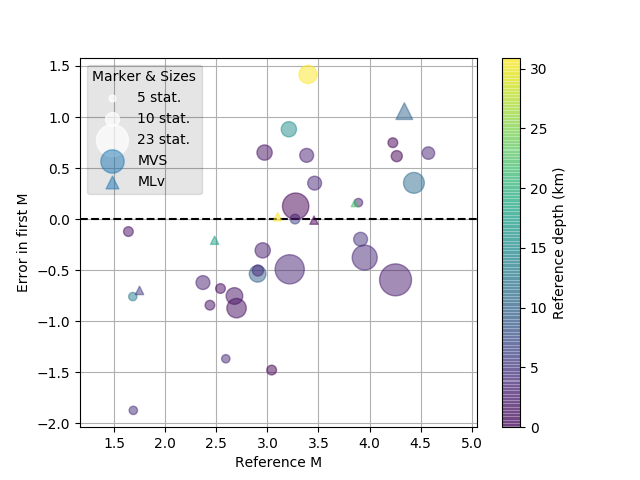

35 Event(s) in Catalog:
2017-02-16T21:48:30.031656Z | +13.522,  -91.405 | 4.659562132 M  | automatic
2017-02-18T23:31:22.642209Z | +14.123,  -91.650 | 4.503060606 M  | automatic
...
2017-02-23T11:27:25.983038Z | +12.480,  -86.682 | 1.894949771 M  | automatic
2017-02-22T10:02:02.543972Z |  +9.491,  -83.706 | 1.608906249 M  | automatic
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [415]:
mags = [ e.magnitudes[-1].mag for e in eewcat_checked.events ]
profs = [ e.origins[-1].depth/1000. for e in eewcat_checked.events ]
mags_stations = [e.magnitudes[-1].station_count for e in eewcat_checked.events ]
m1_errors = [ e.magnitudes[-1].mag-e.magnitudes[0].mag for e in eewcat_checked.events ]
m1_types = [e.magnitudes[0].magnitude_type for e in eewcat_checked.events ]

f, (ax) = plt.subplots(1, 1)
plt.ylabel('Error in first M')
plt.xlabel('Reference M')
plt.grid()
for m in [min(mags_stations),np.mean(mags_stations),max(mags_stations)]:
    sc = ax.scatter(np.mean(mags), 0, m**2, 'w', 'o', label=str(int(m))+' stat.',alpha=0.7 )
ax.axhline(0, linestyle='--', color='k') # horizontal lines
types = ['MVS','MLv','MLh','M']
for i,m in enumerate(['o','^','s','+']):
    matches = [ j for j,t in enumerate(m1_types) if t == types[i] ]
    if matches:
        sc = ax.scatter([mags[j] for j in matches] , 
                   [m1_errors[j] for j in matches] , 
                   [mags_stations[j]**2 for j in matches] ,
                   [profs[j] for j in matches], 
                   m, label=types[i],alpha=0.5,zorder=999)
cb=plt.colorbar(sc)
cb.set_label('Reference depth (km)')
lg = plt.legend()
lg.set_title('Marker & Sizes')
lg.get_frame().set_alpha(0.1)
lg.get_frame().set_color('k')
plt.axis('equal')
print(eewcat_checked)

### How fast was 1rst Mvs ?